***INGRESO LIBRERIAS NECESARIAS PARA EL ENTRENAMIENTO DEL MODELO***

Para este proyecto se usara el clasificacor MobelNetV2 de Keras y tensorflow, se ajustara su arquitectura para que sea facilmente aplicable en dispositivos integrados.

Se usa la libria sklearn para preprocesamiento de data(one hot encoding-binarizacion), segmentar el dataset e imprimir un informe de clasificación.

La libreria imutils nos ayuda a encontrar y enumerar las imagenes del dataset para trabajar con ellas

La libreria matplotlib para observar graficamente los resultados de la red 

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
#Defino los hiperparametros de la red y la ruta del dataset
INIT_LR=1e-4
EPOCHS=25
BS=32
rut_dataset=r'dataset'

***CARGAR IMAGENES Y PREPROCESAMIENTO***


1. Se leen todas la imagenes del dataset y se convierten en arrays, guardando en data las imagenes y en labels los nombres(salida). Posteriormente se convierten en numpy arrays

2. Como los labels son nuestra data de salida, y lo tenemos en formato str(word) le aplicamos one hot encoding para convertirlo en numeros.

In [4]:
#tomo la lista de imagenes de dataset 
imagePaths = list(paths.list_images(rut_dataset))
data=[]
labels=[]

for imagePath in imagePaths:
    # extraer el nombre de la imagen(with_mask, without_mask)->salida
    label = imagePath.split(os.path.sep)[-2]

    # cargar imagen, cambiar tamaño a (224x224) y realizar primer preprocesamiento
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)#scaling pixel intensitis to range[-1,1]

    # actualizar lista de dato(imagen preprocesada)y lista de etiquetas
    data.append(image) #guada las imagenes como array
    labels.append(label)

In [9]:
#convierto la data numpy array
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [12]:
#aplico one hot encoding a labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

***ENTRENAMIENTO***

    1. Dividimos la data en data_train y data_test usando la funcion de sklearn train_test_split, la dividimos en 80 -20
    
    2. Se aplicara una tecnica conocida como data augmentation la cual se usa para generar "nuevas" muestras de entrenamiento a partir de las originale, el objetivo es aumentar la generalizacion del modelo

In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [20]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

***Montando la red...***

Primero le aplicamos una ajuste fino (fine_tuning):
- Se carga MobileNet con los pesos pre-entrenados de ImageNet como modelo base.
- Se construye un nuevo head_model añadida al modelo base previo 
- congelar las capas de base_model, no se actualizaran durante el proceso de retroalimentacion y los de la capa
    principal se ajustaran (loop)

El model se compilara con optimizador adam

In [21]:
#Modelo base, con pesos pre-entrenados de imageNet
baseModel= MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 50s 5us/step


In [22]:
# construccion del head_Model el cual se añadira al base_Model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [23]:
#Colacando el head_model sobre el base_model, sera el modelo que entrenemos
model = Model(inputs=baseModel.input, outputs=headModel)

#loop que congelara todas las capas del base_model
for layer in baseModel.layers:
    layer.trainable = False

In [24]:
# compile model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [25]:
#entrenamiento de la red 
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/25
34/34 [==============================] - 59s 2s/step - loss: 0.4055 - accuracy: 0.8015 - val_loss: 0.1157 - val_accuracy: 0.9891
Epoch 2/25
34/34 [==============================] - 67s 2s/step - loss: 0.1255 - accuracy: 0.9672 - val_loss: 0.0514 - val_accuracy: 1.0000
Epoch 3/25
34/34 [==============================] - 67s 2s/step - loss: 0.0705 - accuracy: 0.9803 - val_loss: 0.0321 - val_accuracy: 0.9964
Epoch 4/25
34/34 [==============================] - 62s 2s/step - loss: 0.0455 - accuracy: 0.9906 - val_loss: 0.0242 - val_accuracy: 0.9964
Epoch 5/25
34/34 [==============================] - 62s 2s/step - loss: 0.0478 - accuracy: 0.9860 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 6/25
34/34 [==============================] - 61s 2s/step - loss: 0.0444 - accuracy: 0.9897 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 7/25
34/34 [==============================] - 66s 2s/step - loss: 0.0311 - accuracy: 0.9944 - val_loss: 0.0145 - val_accuracy: 1.0

In [26]:
# predicciones del modelo con test data
prediccion = model.predict(testX, batch_size=BS)
prediccion = np.argmax(prediccion, axis=1) #probabilidad 

#muestra prediccion en mejor formato
print(classification_report(testY.argmax(axis=1), prediccion,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [29]:
model.save('model_detector2.model', save_format="h5")

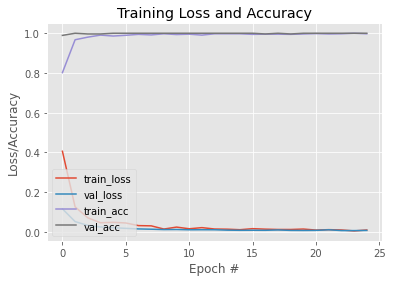

In [28]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])